In [28]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/calibration_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]



image = mpimg.imread('test_images/test5.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 230), sx_thresh=(20, 100), l_thresh=(200,255)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # To get it more clear for right white line, need l threshold
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)| (l_binary == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    return combined_binary
    


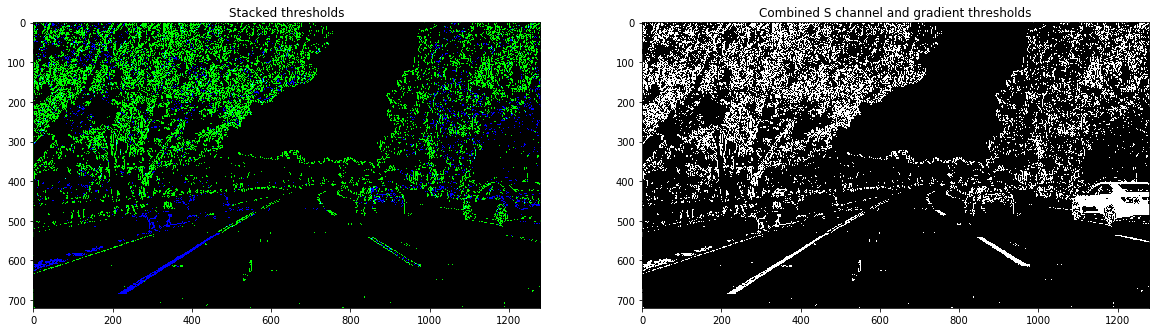

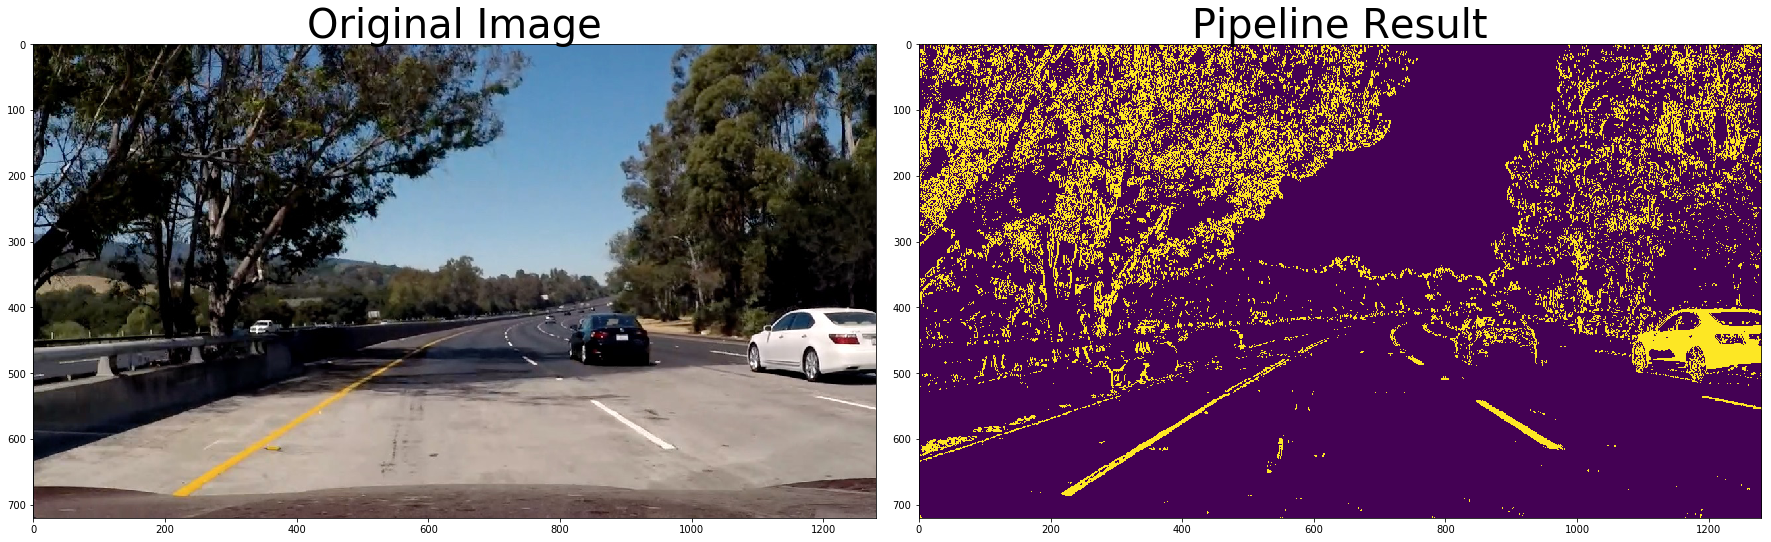

In [29]:
%matplotlib inline

result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



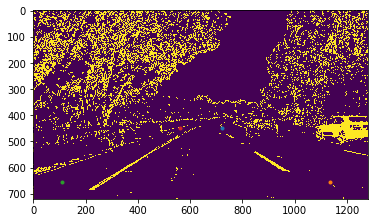

In [30]:
%matplotlib inline

# source image points

plt.imshow(result)
plt.plot(720, 450, '.') #top right
plt.plot(1135,655, '.') #bottom right
plt.plot(110,655,'.') #bottom left
plt.plot(560,450,'.')#top left

In [31]:
# define perspective transform function
def warp(img):
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    #Define calibration box in source and destination coordinates
    img_size = (img.shape[1],img.shape[0])
    
    #Four source coordinates
    src = np.float32(
    [[710,450],[1135,655],[110,655],[560,450]])
    
    #Four desired coordinates
    dst = np.float32(
    [[1135,20],[1135,655],[110,655],[110,20]])
    
    #Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src,dst)
    
    #Could compute the inverse M
    Iver_M = cv2.getPerspectiveTransform(dst,src)
    
    #Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(undist,M,img_size,flags=cv2.INTER_LINEAR)
    
    return warped

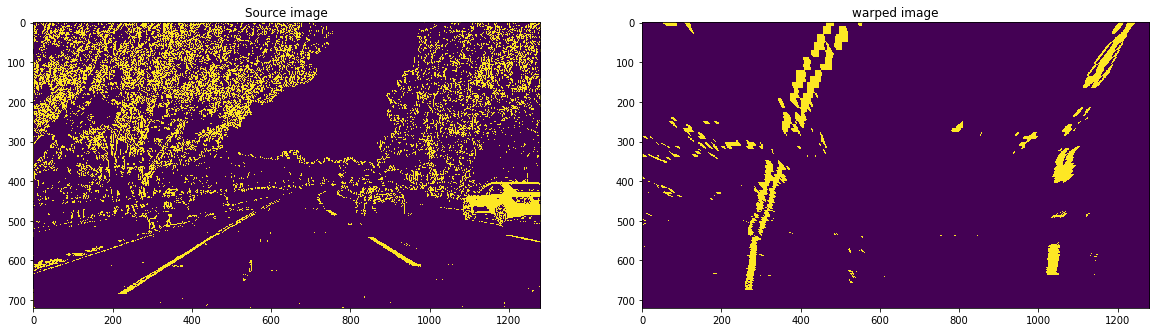

In [32]:
%matplotlib inline

#Get perspective transform
warped_im = warp(result)

#VIsualize undistortion
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

ax1.set_title("Source image")
ax1.imshow(result)
ax2.set_title('warped image')
ax2.imshow(warped_im)

warped im shape[0]: 720 and shape[1]: 1280
histogram shape[0]: 1280
leftx base: 276
rightx base: 1044


(720, 0)

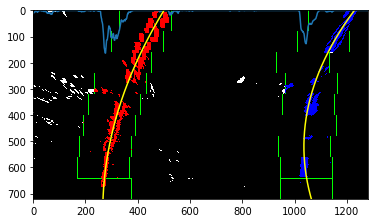

In [33]:
%matplotlib inline
# Try histogram sum
# Take a histogram of the bottom half of the image
print("warped im shape[0]:",warped_im.shape[0],"and shape[1]:",warped_im.shape[1])
histogram = np.sum(warped_im[int(warped_im.shape[0]/2):,:], axis=0)
plt.plot(histogram)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped_im, warped_im, warped_im))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
print("histogram shape[0]:",histogram.shape[0])# histogram has no shape[1]
leftx_base = np.argmax(histogram[:midpoint])
print("leftx base:",leftx_base)
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print("rightx base:",rightx_base)

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped_im.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped_im.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_im.shape[0] - (window+1)*window_height
    win_y_high = warped_im.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)